In [5]:
# ============================
# 1. Import Libraries
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

from mlxtend.frequent_patterns import apriori, association_rules

In [7]:
# ============================
# 2. Load Dataset
# ============================
df = pd.read_csv(url, sep=";")

# Display dataset shape and first rows
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
display(df.head())

Dataset Shape: (165474, 14)

Columns: ['year', 'month', 'day', 'order', 'country', 'session ID', 'page 1 (main category)', 'page 2 (clothing model)', 'colour', 'location', 'model photography', 'price', 'price 2', 'page']


,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


In [9]:
# =====================
# Feature Engineering
# =====================
# Create Date column
df["date"] = pd.to_datetime(df[["year", "month", "day"]])


# User-level aggregation (session ID ~ user proxy)
user_df = df.groupby("session ID").agg({
"order": "count", # total events
"price": ["mean", "sum"], # avg and total spend
"country": pd.Series.nunique, # number of countries visited
"page 1 (main category)": pd.Series.nunique, # unique categories viewed
"page 2 (clothing model)": pd.Series.nunique, # unique clothing models viewed
}).reset_index()


user_df.columns = ["session ID", "events", "avg_price", "total_spent", "unique_countries", "unique_categories", "unique_models"]


print(user_df.head())

   session ID  events  avg_price  total_spent  unique_countries  \
0           1       9  42.111111          379                 1   
1           2      10  50.000000          500                 1   
2           3       6  42.166667          253                 1   
3           4       4  45.250000          181                 1   
4           5       1  57.000000           57                 1   

   unique_categories  unique_models  
0                  4              9  
1                  3              8  
2                  3              6  
3                  2              4  
4                  1              1  


In [10]:
# =====================
# Normalization
# =====================
features = ["events", "avg_price", "total_spent", "unique_countries", "unique_categories", "unique_models"]
X = user_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

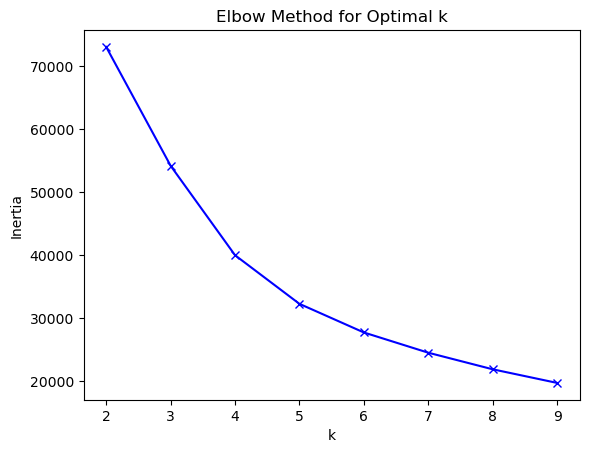

In [12]:
# =====================
# User Segmentation (Clustering)
# =====================
# Elbow Method to find optimal clusters
inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


# Fit KMeans with chosen k
kmeans = KMeans(n_clusters=4, random_state=42)
user_df["segment"] = kmeans.fit_predict(X_scaled)

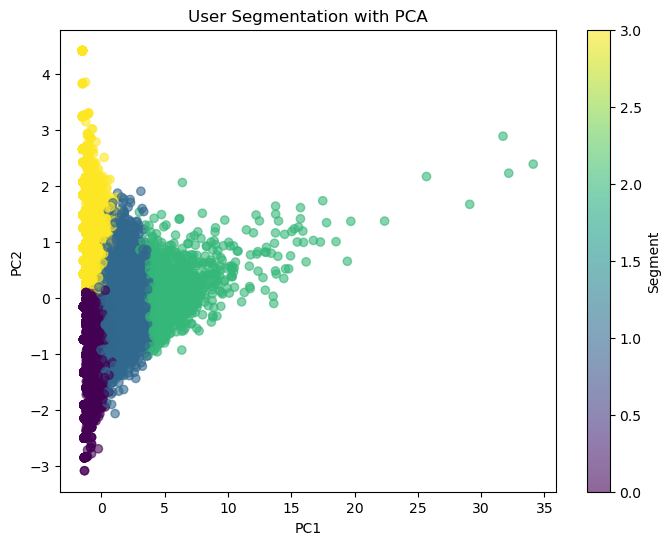

In [13]:
# =====================
# Pattern Detection (PCA for visualization)
# =====================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=user_df["segment"], cmap="viridis", alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("User Segmentation with PCA")
plt.colorbar(label="Segment")
plt.show()

In [14]:
# =====================
# Analyze Segment Profiles
# =====================
segment_profile = user_df.groupby("segment")[features].mean()
print("\nSegment Profiles:\n", segment_profile)


Segment Profiles:
             events  avg_price  total_spent  unique_countries  \
segment                                                        
0         2.946608  37.480940   112.629416               1.0   
1        11.373069  43.793405   496.305596               1.0   
2        38.040634  43.112339  1633.643211               1.0   
3         3.144874  53.467264   163.979852               1.0   

         unique_categories  unique_models  
segment                                    
0                 1.368100       2.737668  
1                 2.884873      10.355873  
2                 3.351833      31.495540  
3                 1.259594       2.912692  
